In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [8]:
data = pd.read_csv('./data_i.csv')
data.head(1)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,1.575318,-0.700949,-0.804477,-0.909496,0.054551,-0.864733,-0.625504,0.570941,1.236305,1.285332,...,1,0,0,1,0,0,1,0,0,0


# Best Features

In [9]:
Feature_Selection = ['p1_d', 'p2_d','min_d','#sp','#dp','first_sp', 'first_dp', 'second_sp','second_dp']

In [10]:
y = data['Type_mine']
X = data[Feature_Selection]

# Holdout

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 1234)

# Naïve Bayes

In [16]:
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

In [17]:
gnb.class_count_

array([1738., 1575.])

In [18]:
gnb.class_prior_

array([0.52460006, 0.47539994])

In [21]:
y_pred = GNB.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [22]:
y_test.shape, y_pred.shape, y.shape, y_train.shape

((1420,), (1420,), (4733,), (3313,))

In [23]:
print("El modelo de Naïve Bayes se equivocó en %d de los %d registros que componen el dataset original"
      % ((y_test != y_pred).sum(), data_I.shape[0]))

El modelo de Naïve Bayes se equivocó en 18 de los 4733 registros que componen el dataset original


([<matplotlib.axis.YTick at 0x15b3b9cbc50>,
 <a list of 2 Text yticklabel objects>)

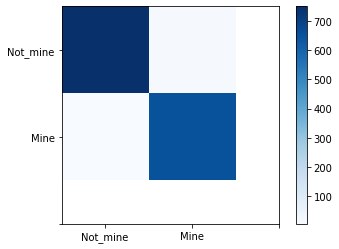

In [24]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [25]:
churm

array([[750,  13],
       [  5, 652]], dtype=int64)

In [26]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.accuracy_score(y_test, y_pred))

Exactitud:  0.9873239436619718
Kappa:  0.9873239436619718


In [28]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))

VN = np.sum(churm[1:3,1:3])
FP = np.sum(churm[0,1:3])
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))

Precisión     :  0.9804511278195489
Recall        :  0.9923896499238964
Especificidad :  0.9804511278195489
F1-score      :  0.9863842662632376


In [30]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VN = np.sum(churm[1:3,1:3])
FP = np.sum(churm[0,1:3])
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Precisión     :  0.9933774834437086
Recall        :  0.9829619921363041
Especificidad :  0.9804511278195489
F1-score      :  0.9881422924901186
